<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Data Quality Anomaly Detection using Statistical Techniques
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Introduction</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In a rapidly evolving business landscape, ensuring the integrity of data within a Datawarehouse is paramount for informed decision-making and operational efficiency. Proactively detecting anomalies or inconsistencies in this data can significantly enhance the performance of business models and applications. By preemptively identifying such discrepancies before they impact end-users, organizations can mitigate potential risks and ensure the reliability of their analytical insights.<br><br>For instance, in the finance sector, preemptive anomaly detection can prevent erroneous financial reporting or fraudulent activities, safeguarding the organization's reputation and compliance with regulatory requirements. Similarly, in e-commerce, identifying inconsistencies in customer data preemptively can optimize marketing strategies and enhance customer experience. Overall, proactive anomaly detection in the Datawarehouse empowers businesses to maintain data integrity, drive informed decision-making, and ultimately, achieve their strategic objectives more effectively.<br><br>While Machine Learning (ML) and Artificial Intelligence (AI) techniques represent powerful tools in data analysis and decision-making, it's crucial to recognize that simpler statistical techniques remain valuable and sometimes more suitable for specific use cases. Teradata is committed to delivering this capability to empower organizations across various domains.</p> 
<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Business Value </b></p>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>Preemptive detection of anomalies and inconsistencies in data. </li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>Data quality monitoring. </li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>Improving performance of business models and applications. </li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>Automated alerts and notifications.</li></p> 
<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Why Vantage? </b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>This demonstration underscores the importance of leveraging foundational statistical methods for data quality anomaly detection, showcasing how such techniques can be effectively applied in practice. By emphasizing the application of these methods, organizations gain insights into the robustness and reliability of their data, which is paramount for informed decision-making processes. To facilitate this process, we have developed a robust framework using the Vantage Analytics Library (VAL) functionality within ClearScape Analytics. This framework is designed to proactively monitor data integrity and identify anomalies before they impact business operations.<br>One of the key advantages of our framework is its expandability and configurability. It can be tailored to suit the specific requirements of different tables and datasets, accommodating the unique needs of each customer's business environment. Moreover, our framework seamlessly integrates with existing Data Quality, Master Data Management (MDM), and Reference Data Management (RDM) solutions, complementing and enhancing their capabilities.<br><br>
By leveraging the In-Database (InDB) VAL functions, our framework offers efficiency and scalability, allowing organizations to analyze large volumes of data without compromising performance. This ensures that anomaly detection processes can keep pace with the growing demands of the business and evolving data landscapes. Additionally, our framework seamlessly integrates with existing Extract, Transform, Load (ETL) pipelines and MDM solutions, facilitating a smooth and streamlined data management workflow. Overall, our pre-emptive detection framework empowers organizations to proactively identify and address data anomalies, thereby safeguarding data integrity, enhancing decision-making processes, and ultimately, driving better business outcomes.<br> More information about the framework can be found at <a href="https://storage.googleapis.com/clearscape_analytics_documents/Experience/UseCases/Data_Anomaly/Anomaly%20Detection%20POC%20Runbook.pdf">Click here.</a></p>


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>1. Connect to Vantage.</b></p>

In [ ]:
from teradataml import *

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Modify the following to match the specific client environment settings
display.max_rows = 5

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We will be prompted to provide the password. We will enter the password, press the Enter key, and then use the down arrow to go to the next cell.</p>

In [ ]:
%run -i ../startup.ipynb
eng = create_context(host = 'host.docker.internal', username='demo_user', password = password)
print(eng)

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Setup for execution of notebook. Begin running steps with Shift + Enter keys.</p>

In [ ]:
%%capture
execute_sql('''SET query_band='DEMO=Data_Quality_Anomaly_Detection_Python.ipynb;' UPDATE FOR SESSION; ''')

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have provided data for this demo on cloud storage. In this demo since we are using Temporal table we will be creating databases and tables in local storage and use them in the notebook. Please execute the procedure in the next cell.</p>


In [ ]:
%run -i ../run_procedure.py "call get_data('DEMO_DataAnomaly_cloud');" 
# takes about 20seconds, estimated space: 0 MB
#%run -i ../run_procedure.py "call get_data('DEMO_DataAnomaly_local');" 
# takes about 35 seconds, estimated space: 11 MB

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Optional step – if you want to see status of databases/tables created and space used.</p>

In [ ]:
%run -i ../run_procedure.py "call space_report();"

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>2. High-Level Solution Design</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C;color:#00233C'> The process of anomaly data detection involves comparing the distribution and variation of data between two defined time intervals: <b>New</b> data and <b>Previous</b> data. These intervals are determined based on input parameters, namely the new delta days and previous delta days. Let's break down how this works:
    <li style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Definition of New and Previous Data</b>: The time interval for the "New" data is determined by subtracting the new delta days from the current time. For example, if the customer specifies a new delta of 90 days, the "New" data would encompass the data from the last 90 days leading up to the current time. Similarly, the time interval for the "Previous" data is determined by subtracting both the new delta days and the previous delta days from the current time. This creates an interval that spans from (current time - new delta days - previous delta days) to (current time - new delta days).</li> 

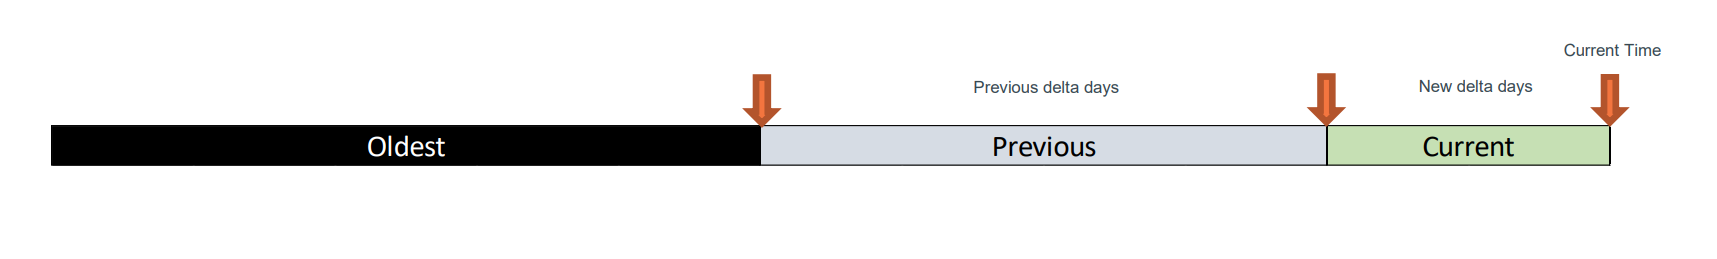

<li style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Comparison of Data</b>: Once the New and Previous data intervals are defined, the process compares the distribution and variation of data within these intervals. This comparison allows for the detection of any anomalies or deviations between the two datasets. Anomalies may include outliers, unexpected patterns, or significant changes in data behavior.</li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Exclusion of Oldest Data</b>: It's important to note that the process excludes the oldest data from consideration. This ensures that only the most relevant and recent data is analyzed for anomalies. By focusing on recent data, the process prioritizes identifying issues that are more likely to impact current business operations and decision-making.</li>

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Configuration options</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The framework allows us to configure the list of tables to be included in the anomaly detection process. It also gives us option to include only specific columns from the tables. The thresholds to trigger an anomaly/alert can also be configured using a parameter table.</p>

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Process Flow</b></p>

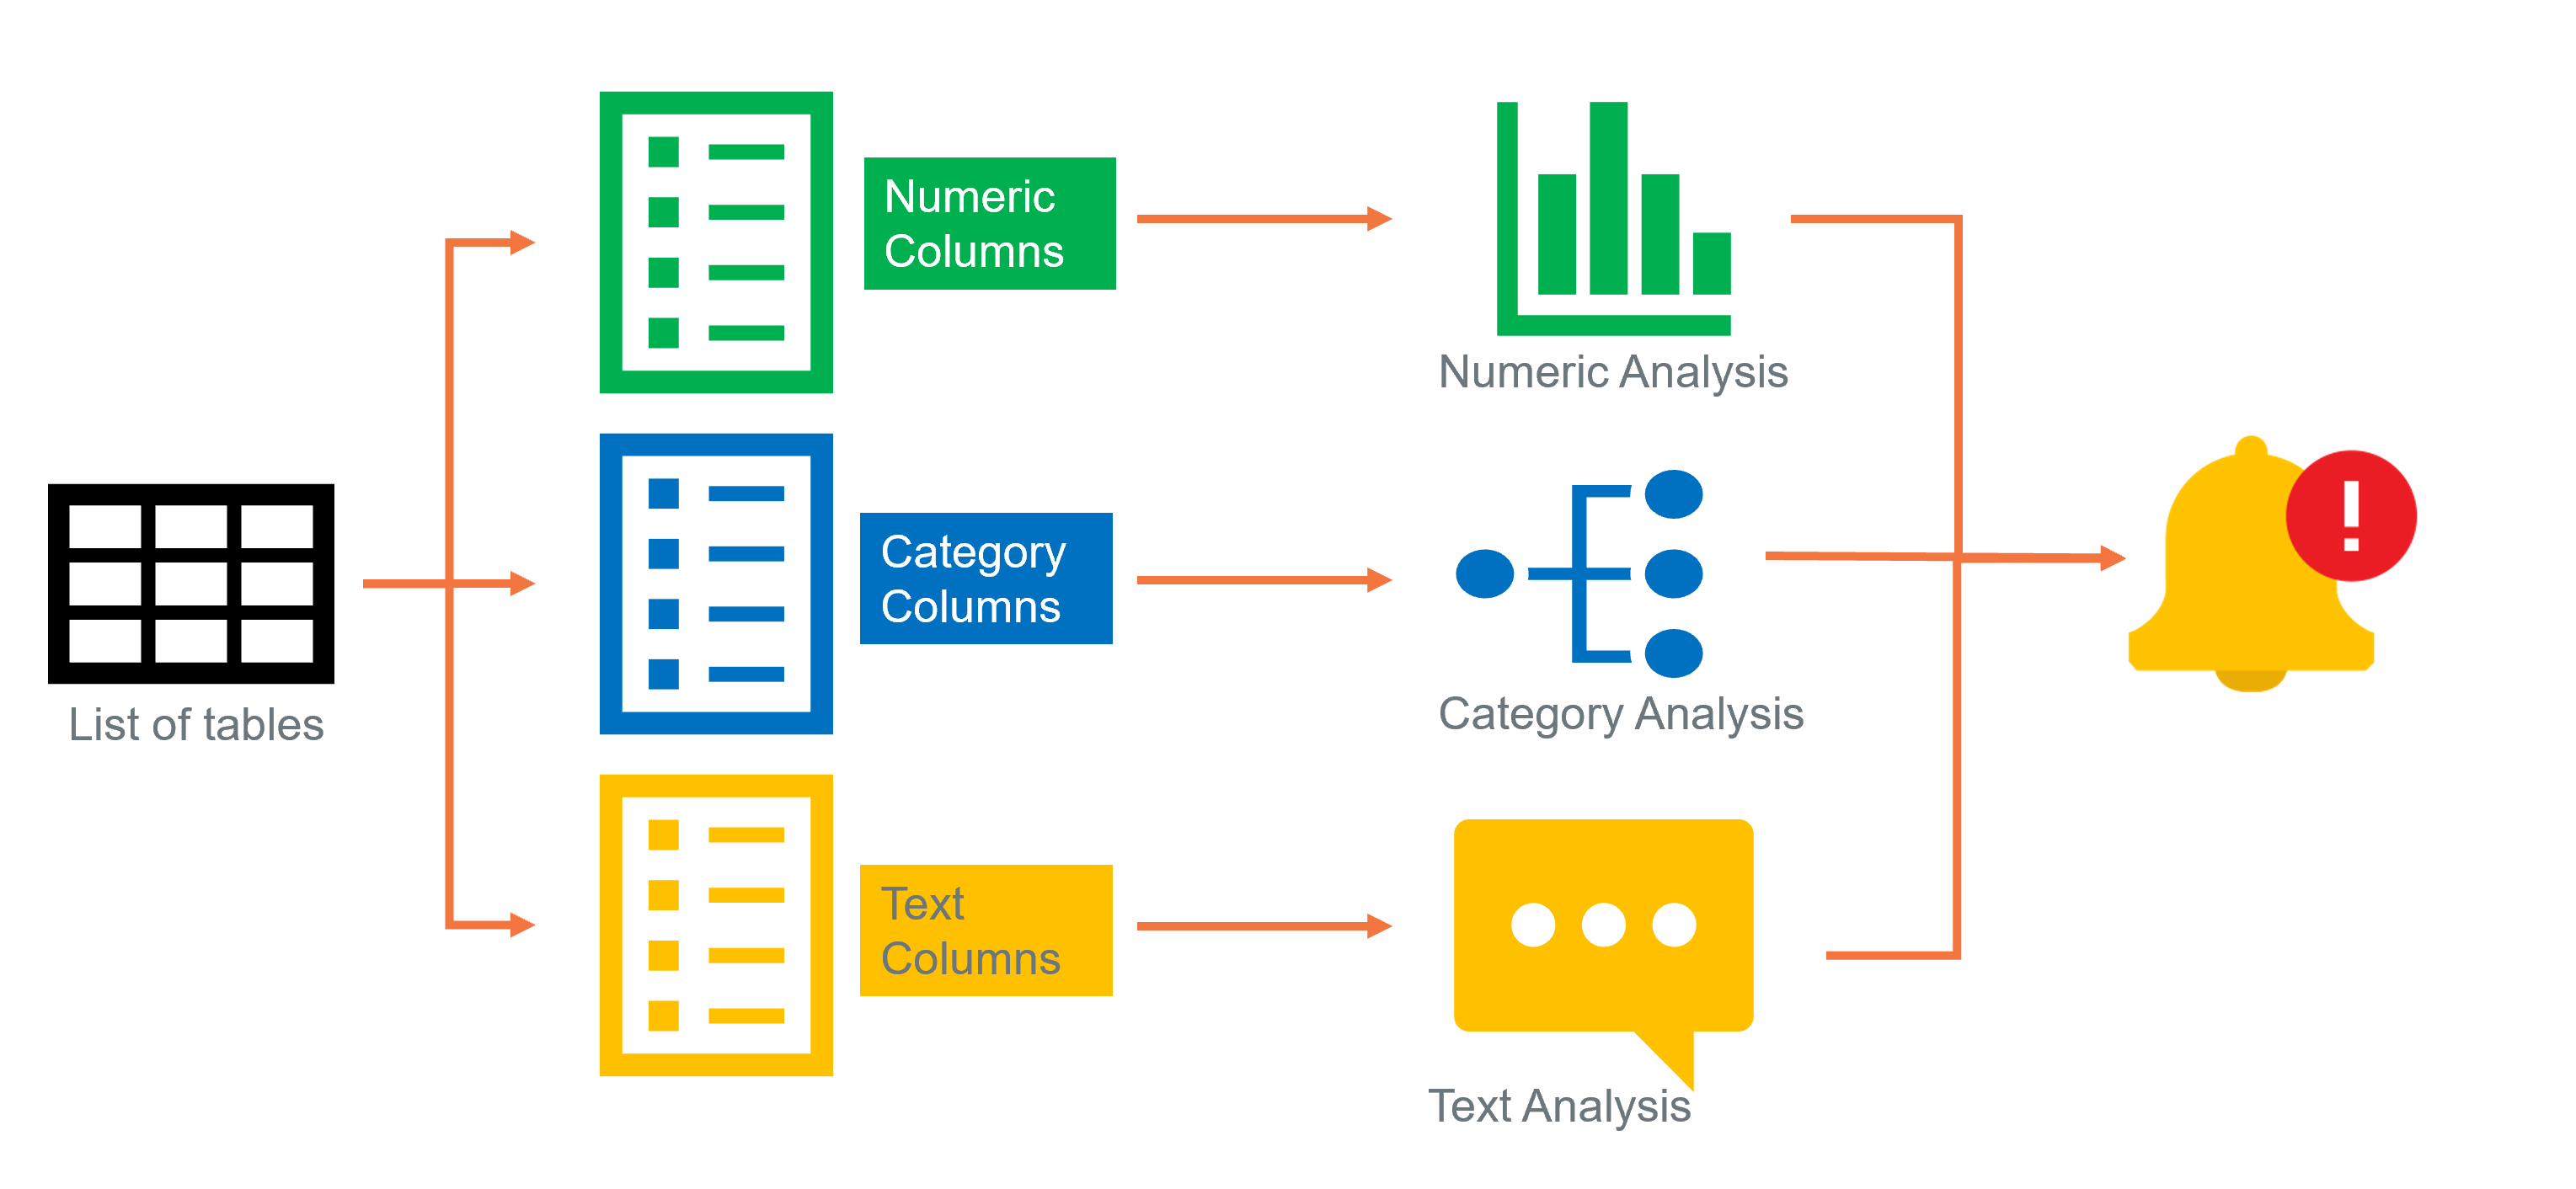

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The framework supports the following data types:
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li ><b>Numeric columns</b>: including INT, BIGINT, FLOAT, DECIMAL</li>
    <li><b>String columns</b>: including CHAR, VARCHAR</li>
    <li><b>Category columns</b>: Both numeric and string with unique value (predefined value, controlled by the parameter table)</li></ul></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Statistics Analysis for numeric column</b>:
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Histogram Analysis with Data Drift</li>
    <li>Statistics: Min, Max</li>
    <li>Outlier</li>
    </ul>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Statistics Analysis for string column</b>:
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>New character that was not being used before</li>
    <li>Configuable special characters (like @%~ etc) that was not being used before</li>
        </ul>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Statistics Analysis for category column</b>:   
    <ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>New unique value(s)</li>
    <li>Data Drift</li>
        </ul>
    </p>  


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>3. Setting the Framework</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The package includes setting.yaml file in which we can specify the Database information and locations where we want the framework to install.<br><b>VAL_DB</b> is the database where Vantage Analytics Library package is installed<br><b>Proc_Db</b> is the database where all the Teradata Virtual dataframes (views) will be created for process<br><b>Work_Db</b> is the database where the staging table(s) will be created for process<br><b>Data_Db</b> is the database for the setting and result tables will be created<br>After the parameters are set we will run the DQ_initial.py script which creates all the input and output tables and views used by the framework. It will also set the default threshold values used for generating the alerts. We can modify these threshold values as per the customer requirements.<br><i>Note* This script should be executed once during the initialization of the framework.</i></p>


In [ ]:
%run -i DQ_initial.py

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Below is the list of input control tables that are used to run the process and main output table which will store the result of the process.</p>

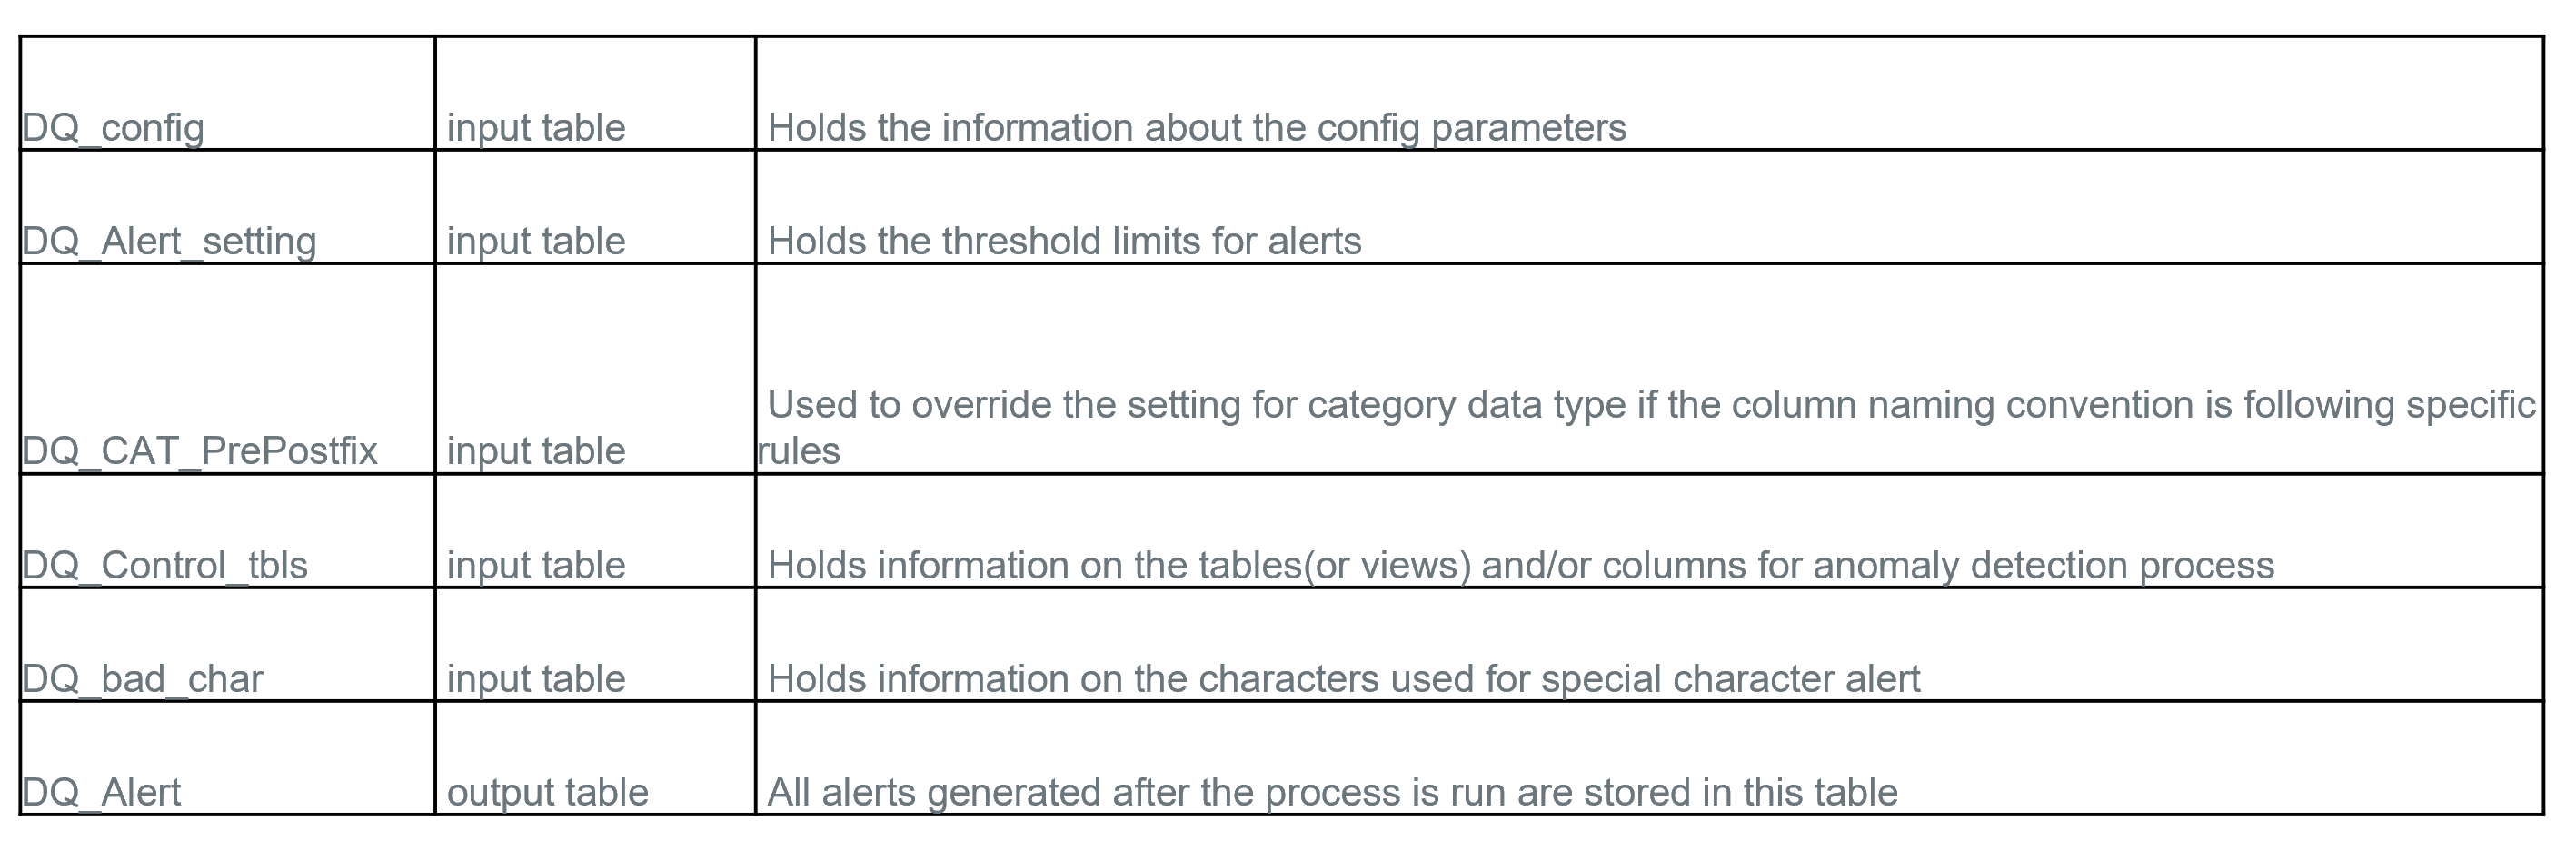

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>For our demonstration we will use customer_info table. Let us see how the data in the table looks like.<p>

In [ ]:
tdf = DataFrame(in_schema("DEMO_DataAnomaly" ,"Customer_Info"))
tdf

In [ ]:
tdf.shape

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From the above results we can see that the customer table has 12k records and have six columns which are numeric and categorical. Let us check the dates in the table, we will build our previous and new delta days(explained in section 2) based on its value.<p>

In [ ]:
tdf2 = DataFrame.from_query('''
        select min(load_ts) as min_date, max(load_ts) as max_date 
        from DEMO_DataAnomaly.Customer_Info;''')
tdf2

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>As we can see we have data from 1st Jan 2022 to 31st May 2022 in our sample table. Let us now insert the values in the control table DQ_control_tbls for framework process to run. DQ_control_tbls table lists the table we want the framework to check for anomaly.</p>

In [ ]:
execute_sql('''Insert into demo_user.DQ_control_tbls values 
              ('DEMO_DataAnomaly','Customer_Info',null,'M','load_ts',null,1);''')

In [ ]:
tdf3 = DataFrame(in_schema("DEMO_User" ,"DQ_control_tbls"))
tdf3

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The columns of the DQ_Control_tbls represent below:<br><ul style = 'font-size:16px;font-family:Arial;color:#00233C'><li><b>DatabaseName</b>: Database name for the target table or view</li>
    <li><b>TableName</b>: Target table or view name</li>
    <li><b>ColumnName</b>: [Optional] Target column. To include all the eligible column, set this field to NULL</li>
    <li><b>ToleranceLevel</b>: Tolerance level for the alert: High, Medium or Low</li>
    <li><b>TsColumn</b>: Date or timestamp column that indicates when the data is updated/inserted. The 
corresponding TsColumn have to be one of the following format:</li>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
<li>Date</li>
<li>Timestamp(0)</li>
<li>Timestamp(6)</li>
<li>VARCHAR with format in ‘yyyy-mm-dd hh:mi:ss’</li>
</ul>
    <li><b>InactiveTsColumn</b>: [Optional] Date or timestamp column that indicates when the data is set to 
        inactive/expire.<li><b>ActiveInd</b>: 0 – this row is not being used; 1 – this row is included</li>
</ul>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Both table and column level setting are allowed. If both exist, table level setting will take higher priority for the tolerance setting. We have initialized framework to run Anomaly detection for the customer_info table. Let us also take a look at the DQ_Config table which sets the values for new and prv time durations for the process.</p>

In [ ]:
tdf4 = DataFrame(in_schema("DEMO_User" ,"DQ_config"))
tdf4

<p><ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li><b>delta_new</b> is the # of days the data is being considered as new data</li>
    <li><b>delta_prv</b> is the # of days the data is being considered as prv data (and before delta_new days)</li>
    <li><b>outlier_method</b> one of the two values S/B. S is Tukey's Method for Identifying Outliers based on quantiles or B which is Z-score method based on mean and standard deviation of data.
    <li><b>category_max_unq</b> is maximum # of unique value that the column will be tagged as Category type column</li>
    <li><b>DATE_USAGE</b> accepts 2 values CUR or MAX. When this parameter is set to CUR, it will use the current date as reference point; when this parameter is set to Max, it will get the maximum date for each table and use it as reference point</li>
    <li><b>enable_chr_search_ind</b> allows 3 values: 0~2</li>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
<li>0: No new character altert. Set to this value to get the best performance</li>
<li>1: Search the special character that is included in DQ_bad_char table, and create 
the alert if the special characters found in new dataset but not in prv dataset</li>
<li>2: Search any characters that are being used in new dataset but not in prv dataset. Beware this setting will require a lot more CPU/IO usage to breakdown all the strings</li>
</ul>
</ul></p>


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The tolerance is set in the DQ_Alert_setting table and is as below we can make adjustment if necessary.</p>
    

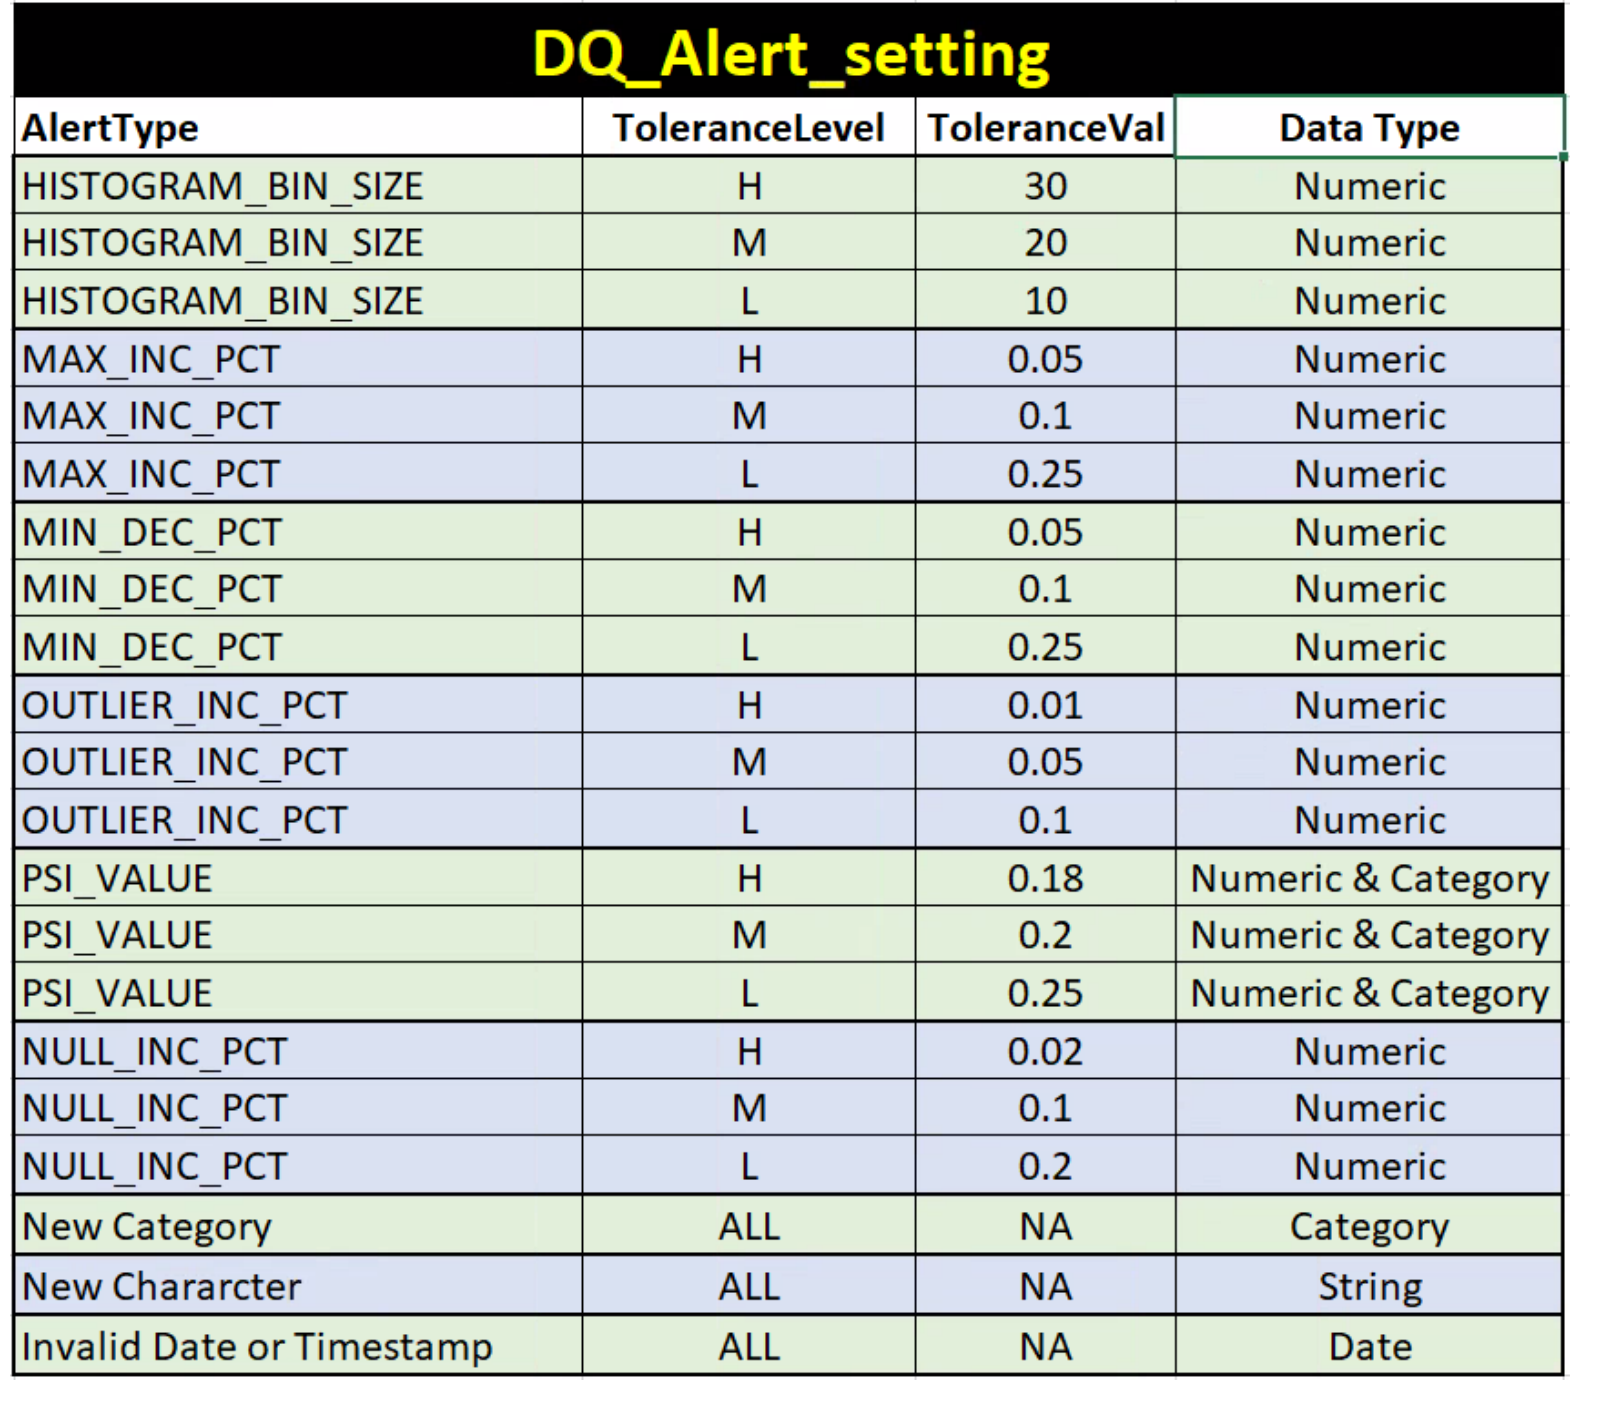

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>4. Running the Framework</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Now our framework is set, let us run the process and check if our data has any anomaly.</p>

In [ ]:
%run -i VAL_DQ_main.py

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>5. Alerts from the Framework</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The alerts from the process are stored in the DQ_Alert table. Let us take a look at the alert values generated from our sample data.</p>

In [ ]:
tdf5 = DataFrame.from_query("select * FROM DQ_alert WHERE sessionid = 1;")
tdf5

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>As we can see different types of alerts like <b>new category, changed distribution and increase outliers</b> are detected for the sample table we have used based on the tolerance level setting set in the DQ_Config table in previous steps. The Alert type Changed Distribution   is based on PSI value. The Population Stability Index (PSI) is a way of measuring how much things have changed between the previous data and the current data that we are checking. Similarly the alert type New Category specifies that there is new value coming in for the column which was not in the data before and the alert type Increase Outliers compares the incoming data values with previous values either by mean or standard deviation based on the outlier method specified in config table. <br>Let us take a look deeper at the changed distribution of <b>income</b> from previous data.</p>

In [ ]:
tdf6 = DataFrame.from_query('''SELECT
 xbin, xbeg, xend, prev_cnt, new_cnt, prev_pct, new_pct
FROM DQ_hist_bin_comp
WHERE sessionid = 1
AND DatabaseName = 'DEMO_DataAnomaly'
AND tablename = 'Customer_Info'
AND xcol ='income'
;
''')
tdf6

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Let us plot this data to get better understanding.</p>

In [ ]:

df = tdf6.to_pandas()
df['x_lbl'] ='['+ df['xbeg'].astype(str)+'-'+df['xend'].astype(str)+']'
df.set_index('xbin', inplace=True)

# Set the x-axis labels
x_labels = df['x_lbl']

# Set the bar width
bar_width = 0.35

# Create the figure and axis
plt.figure(figsize=(20, 8))

# Plot the bars
plt.bar(df.index, df['prev_pct'], bar_width, label='Previous % of Income', color='darkorange')
plt.bar(df.index + bar_width, df['new_pct'], bar_width, label='New % of Income', color='darkblue')

# Set x-axis labels and title
plt.xlabel('xbeg - xend',fontsize=12)
plt.ylabel('Percentage',fontsize=12)
plt.title('Comparison of Income between Previous and New data ',fontsize=20)
plt.xticks(df.index + bar_width / 2, x_labels, rotation=45, ha='right')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In the above chart we can see distribution of income in previous and current data. We can see that in previous data the highest income band was 25003-25161 with 20% of income in this band where as in current data it has dropped to 13%.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Let us now take a look at 'New Catgeory' alert generated.</p> 

In [ ]:
tdf7 = DataFrame.from_query('''SELECT
 xcol, xuniquevalue,
 sum_prv_cnt, sum_new_cnt,
 CAST(sum_prv_cnt AS FLOAT) /SUM(sum_prv_cnt) OVER () AS prv_pct,
 CAST(sum_new_cnt AS FLOAT) /SUM(sum_new_cnt) OVER () AS new_pct
FROM DQ_unq_val_cnt
WHERE sessionid = 1
AND DatabaseName = 'DEMO_DataAnomaly'
AND TableName = 'Customer_Info'
and xcol = 'acc_type';
''')
tdf7

In [ ]:
df_unq = tdf7.to_pandas()

# Set the x-axis labels
x_labels = df_unq['xuniquevalue']

# Set the bar width
bar_width = 0.35

# Create the figure and axis
plt.figure(figsize=(20, 8))

# Plot the bars
plt.bar(df_unq.index, df_unq['prv_pct'], bar_width, label='Previous %', color='darkorange')
plt.bar(df_unq.index + bar_width, df_unq['new_pct'], bar_width, label='New %', color='darkblue')

# Set x-axis labels and title
plt.xlabel('Account Type',fontsize=12)
plt.ylabel('Percentage',fontsize=12)
plt.title('Comparison of Account Type between Previous and New data',fontsize=20)
plt.xticks(df_unq.index + bar_width / 2, x_labels, ha='right')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In the above chart we can clearly see that the new category coming in for Account Type. Similarly we can check for other alert outputs generated for other columns. As we know that Vantage can easily integrate with 3rd party reporting tools, the alert tables can also be used to create a dashboard which will help in easy monitoring of the system. Below is the image of sample dashboard created in PowerBI which shows the alerts generated by the process after the run.</p>

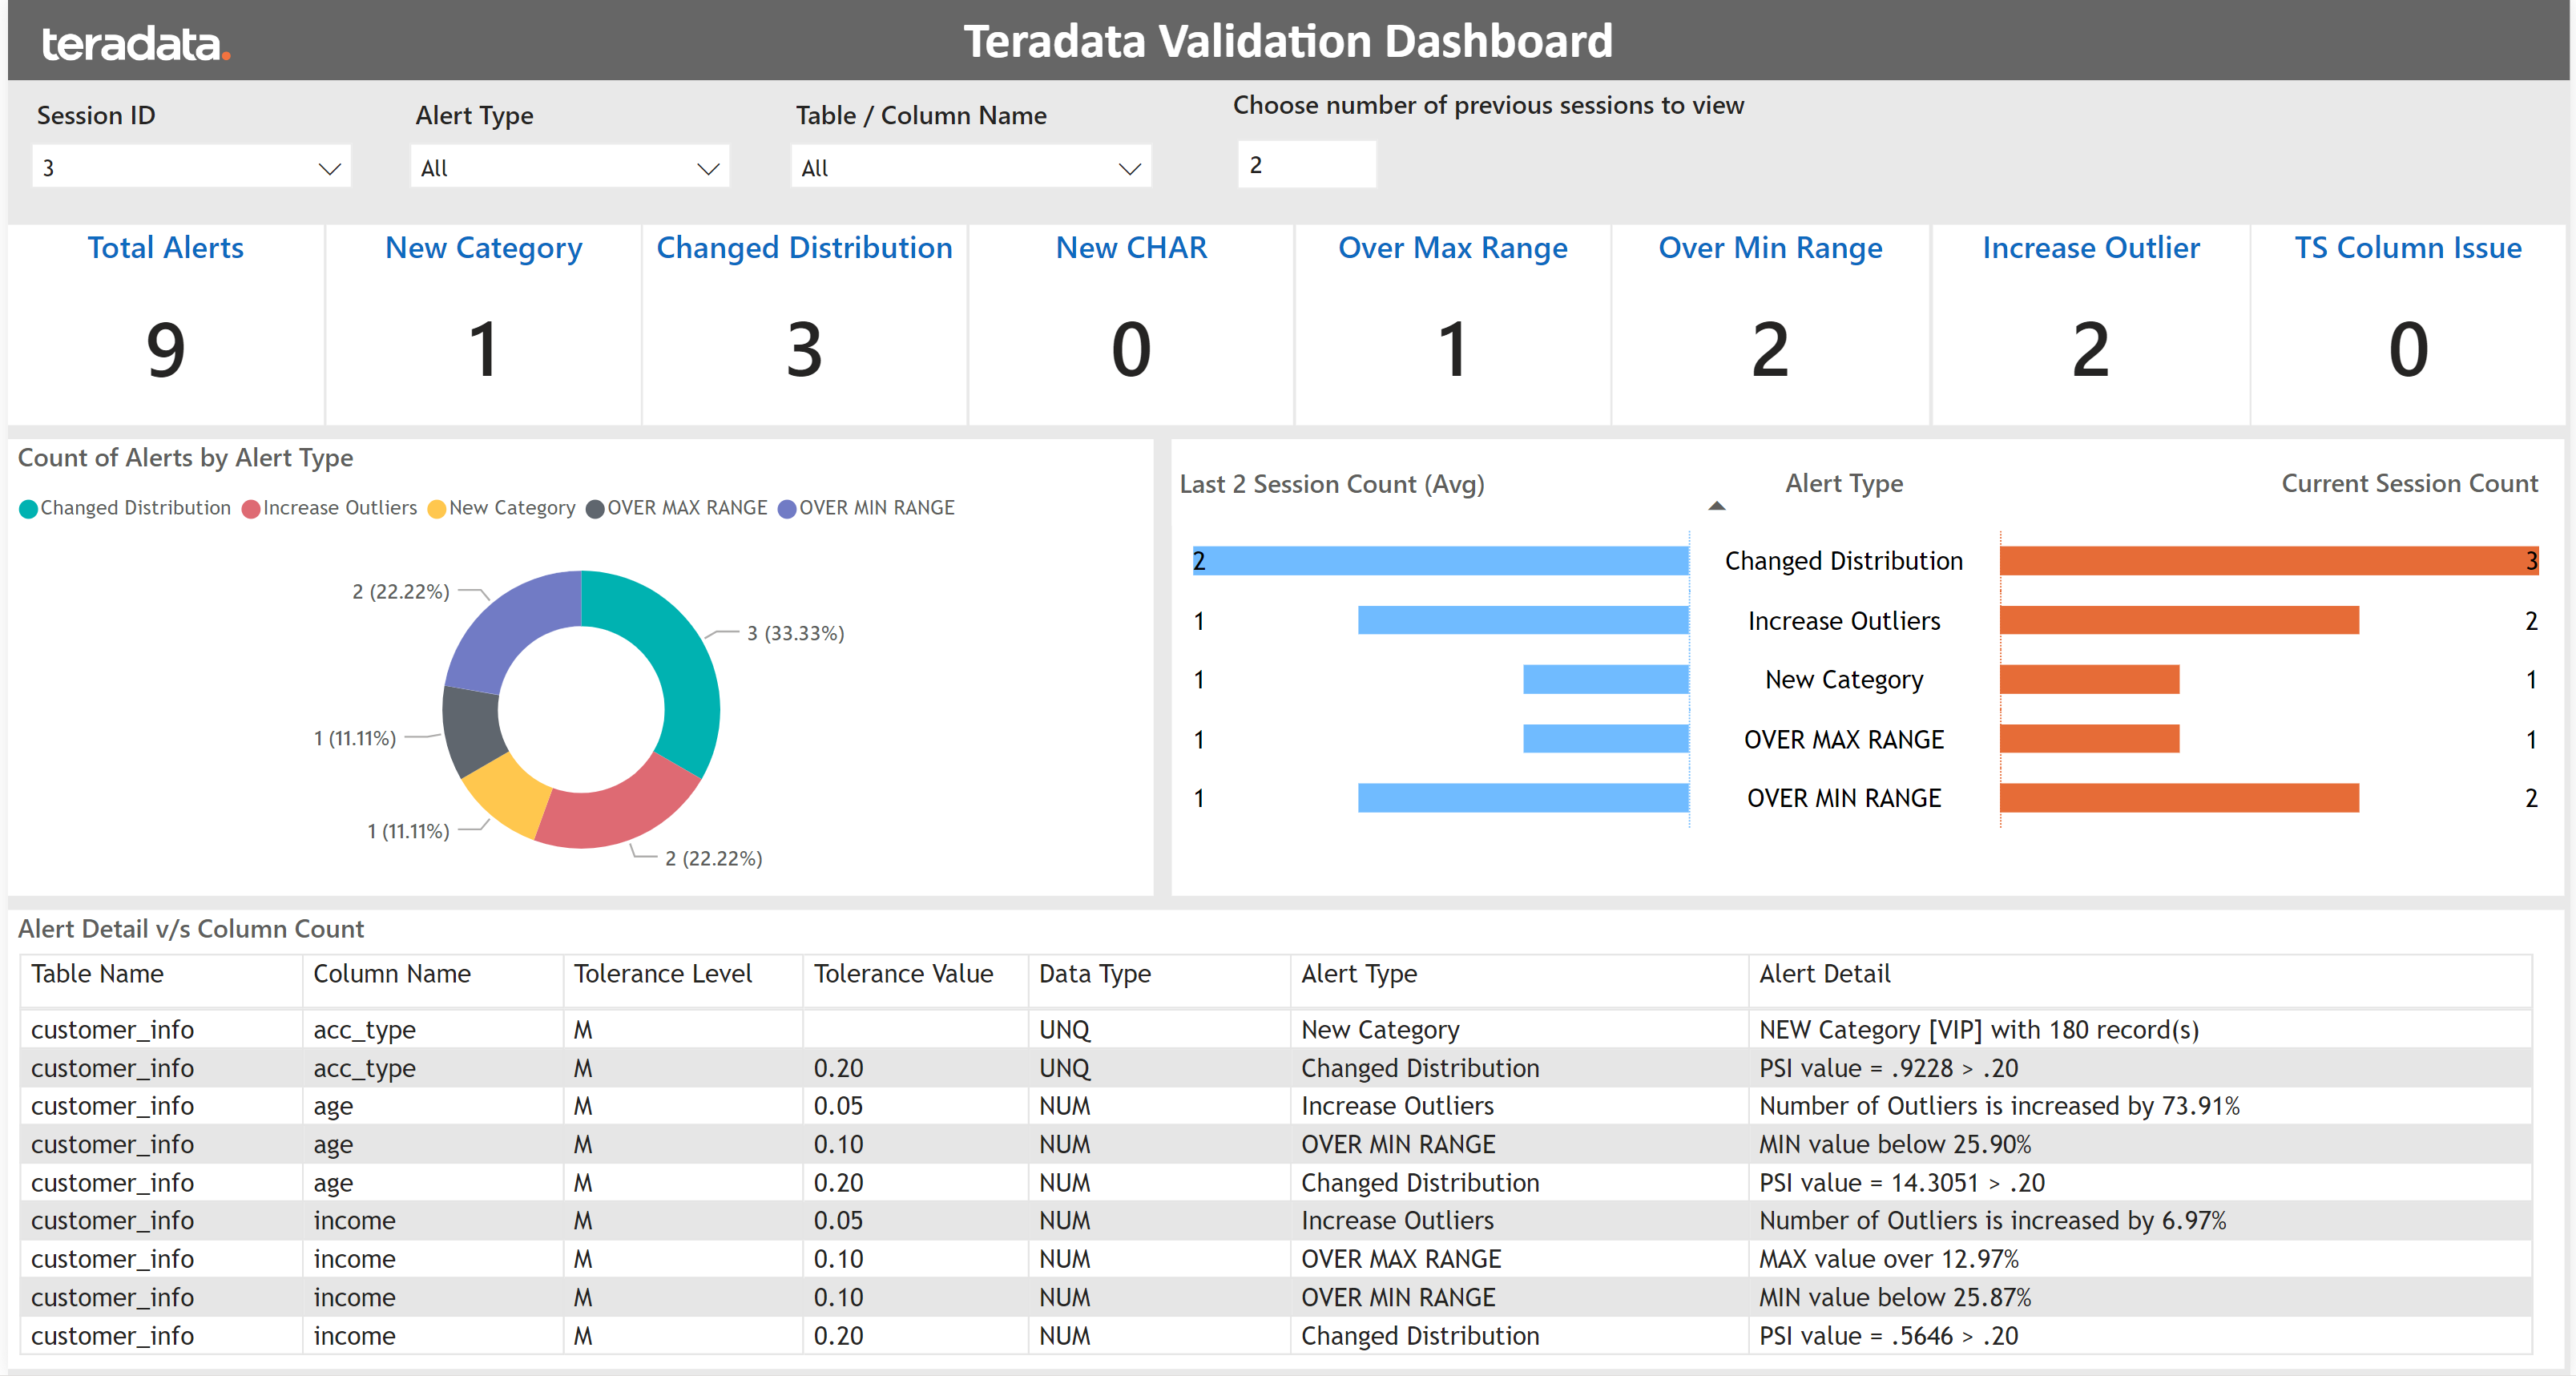

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above is the sample dashboard which highlights all the alerts in one location. It shows the total alerts generated, the types of alerts and also compares the alerts from the previous run.It also has a drill through which gives the details of the alert generated.</p>

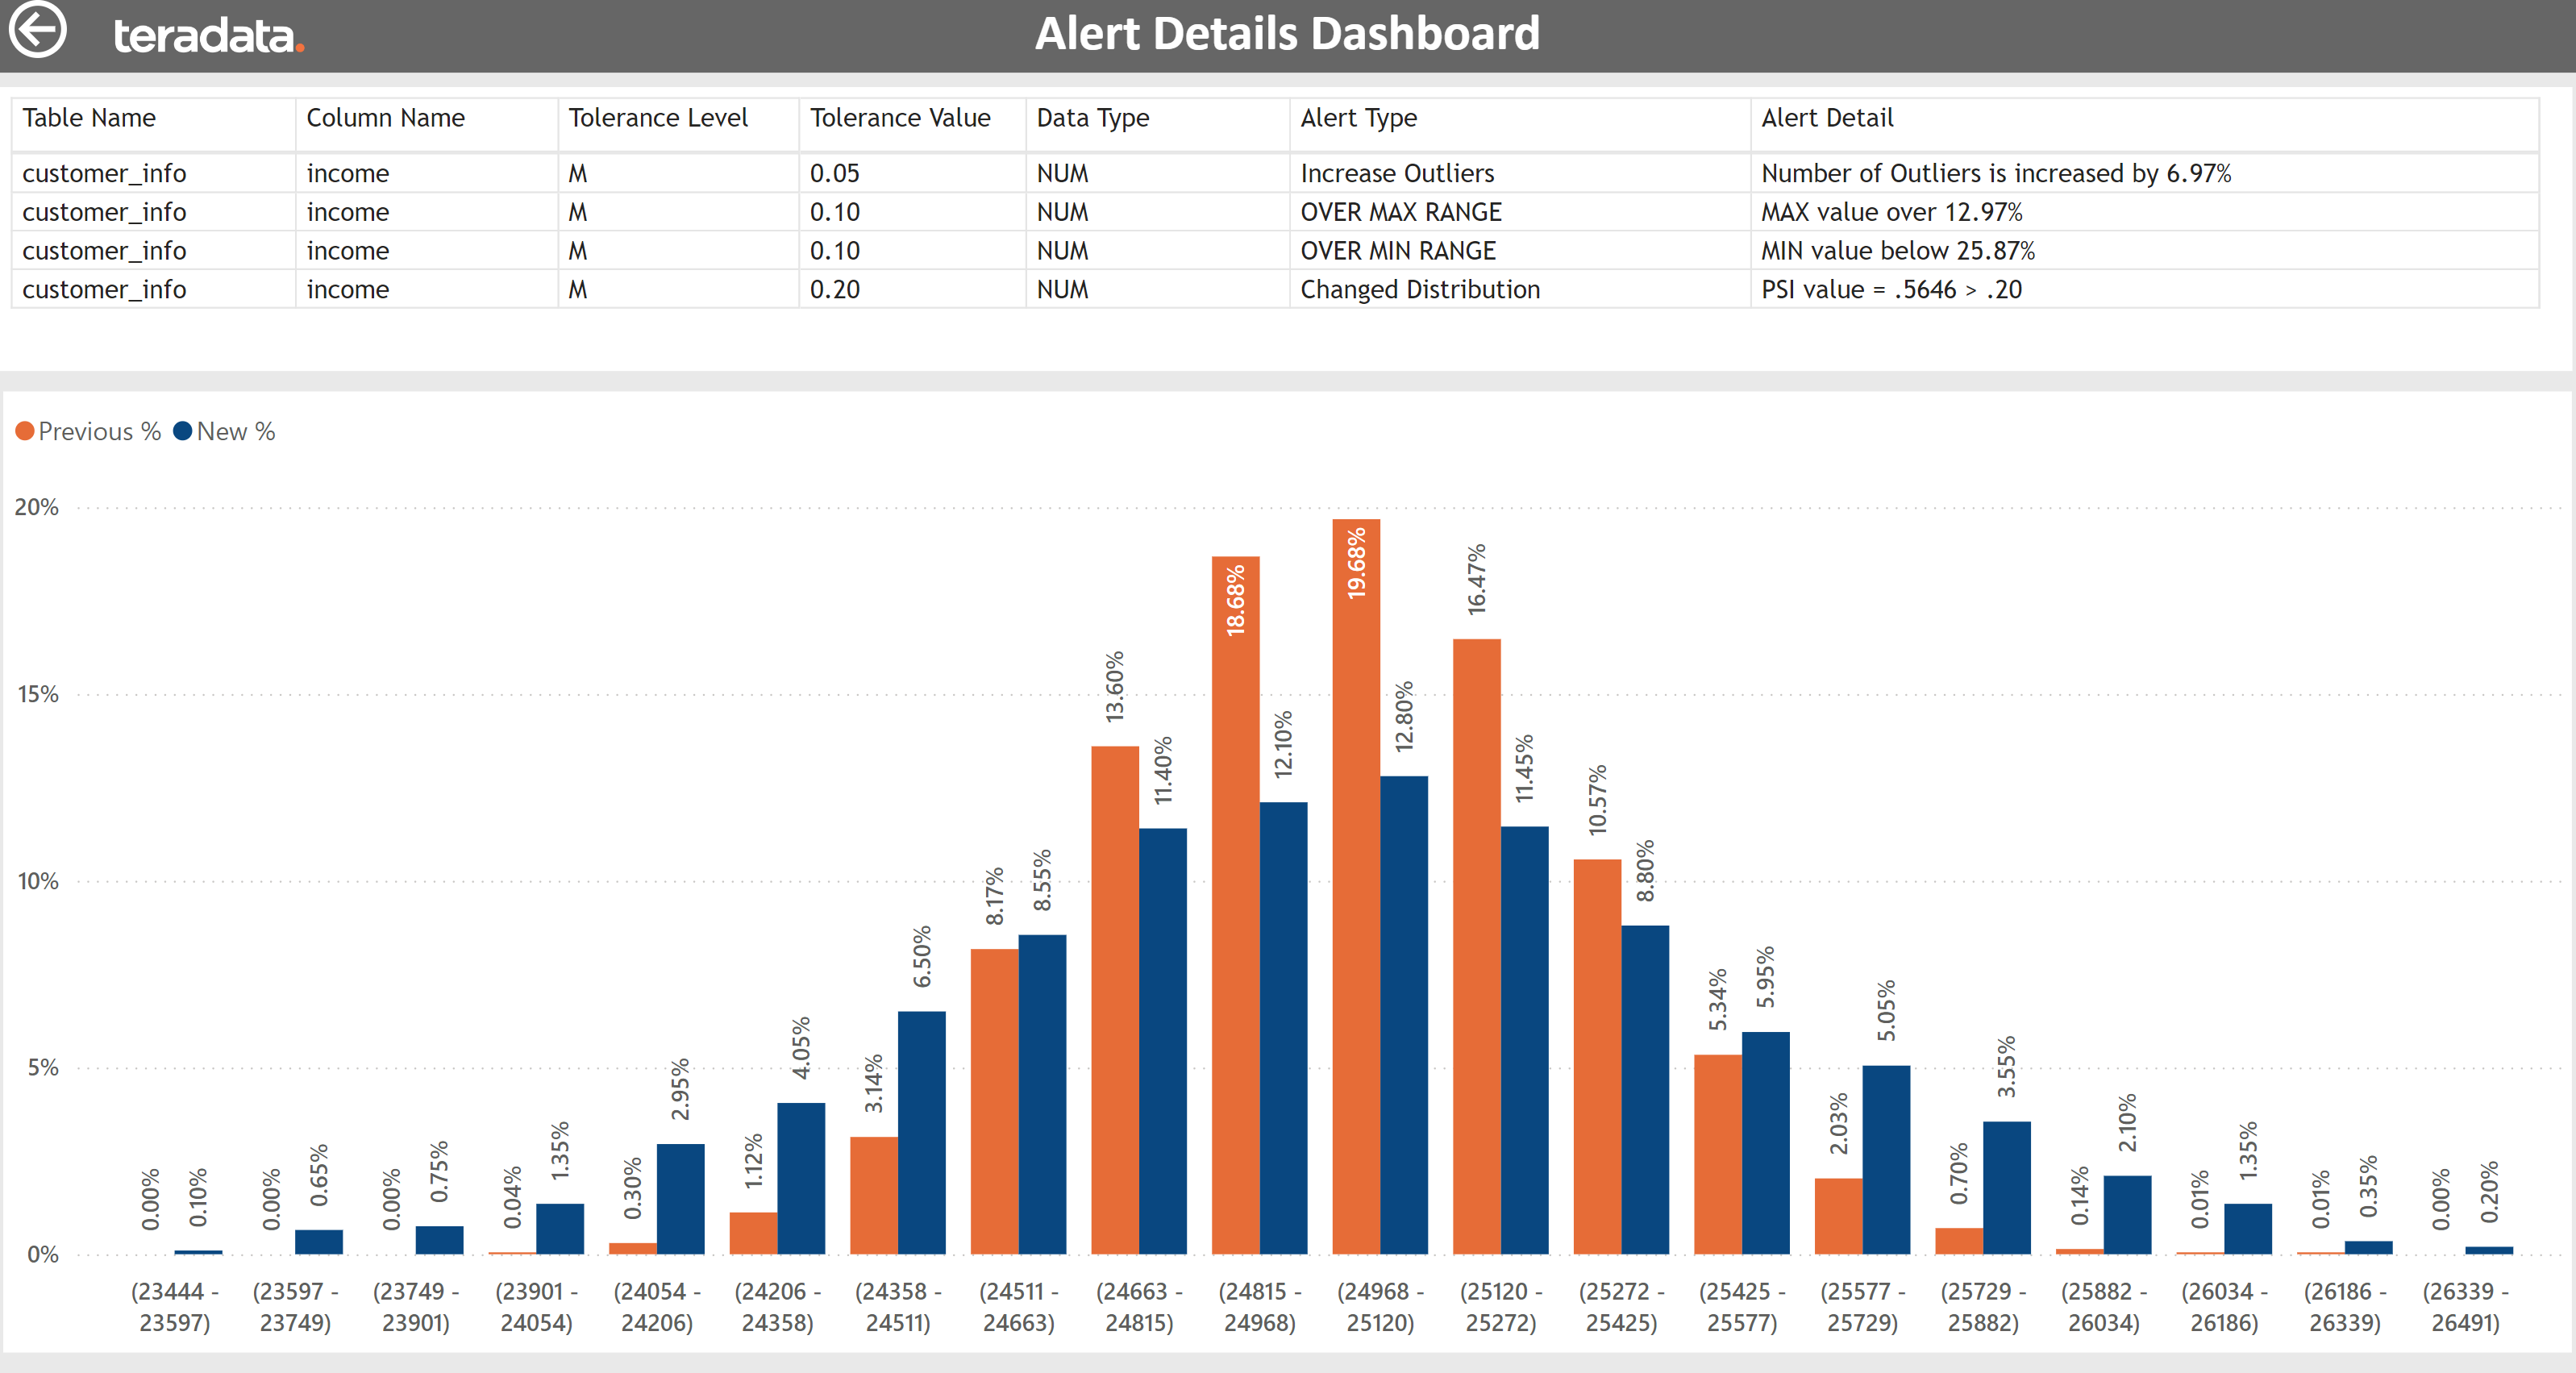

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b> Conclusion</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Teradata's commitment to providing a holistic approach to data analysis encompasses the integration of both advanced ML/AI methodologies and traditional statistical techniques. This balanced approach ensures that organizations can effectively address diverse data challenges, optimizing their analytical capabilities while maintaining a pragmatic perspective on methodology selection.<br>
In summary, this demo serves as an illustrative example of how simpler statistical techniques complement advanced ML/AI methodologies, particularly in scenarios where data quality anomaly detection is a priority. Teradata remains dedicated to equipping organizations with a comprehensive toolkit to navigate the complexities of modern data analysis and drive actionable insights.</p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6. Cleanup</b></p>
<p style = 'font-size:18px;font-family:Arial;color:##00233C'><b>Work Tables</b></p>
<p style = 'font-size:16px;font-family:Arial;color:##00233C'>We need to clean up our work tables to prevent errors next time.</p>

In [ ]:
views = ['DQ_Alert_vw','DQ_hist_bin_comp']
for view in views:
    try:
        db_drop_view(view_name=view)
    except:
        pass  

In [ ]:
tables = ['DQ_hist_psi','DQ_char_hist','DQ_Hist_info_hist','DQ_config','DQ_bad_char' , 'DQ_vol_filter_tbl','DQ_smirnov_test_result','DQ_control_tbls','DQ_Alert_setting','DQ_unq_val_cnt','DQ_CAT_PrePostfix','DQ_Alert','DQ_process_columns','DQ_Outlier_info','DQ_Stat_info_hist']

# Loop through the list of tables and execute the drop table command for each table
for table in tables:
    try:
        db_drop_table(table_name=table)
    except:
        pass 

<p style = 'font-size:20px;font-family:Arial;color:#00233C'> <b>Database and Tables </b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The following code will clean up tables and databases created above.</p>

In [ ]:
%run -i ../run_procedure.py "call remove_data('DEMO_DataAnomaly');"    

In [ ]:
remove_context() 

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>Required Materials</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Let’s look at the elements we have available for reference for this notebook:</p>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>Filters:</b> 
    <li style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Industry:</b> All</li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Functionality:</b> Solution Accelerator</li> 
<li style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Use Case:</b> Data Anomaly Detection</li></p>

<footer style="padding-bottom:35px; background:#f9f9f9; border-bottom:3px solid #00233C">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            © 2024 Teradata. All rights reserved.
        </div>
    </div>
</footer>